In [1]:
from Peak_Search_Linien import ini_peak_search, mod_peak_search,zero_measure,fir_measure
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from linien_utils import get_waveform, set_scan_range
from linien_client.connection import LinienClient
from scipy.signal import find_peaks

import time
import tqdm
import csv
resource_name_windfreak = "COM8"
synthd = SynthHD(resource_name_windfreak)
synthd.init()
rf_out = 0
c = LinienClient(
    host="10.10.222.30",
    user="root",
    password="root"
)
c.connect(autostart_server=True, use_parameter_cache=True)


Try to connect to 10.10.222.30:18862
Connection established!


Peak Search

In [7]:
synthd[rf_out].enable = False
zero_amp_all = []
fir_amp_all = []
pow_max_all = []
scan_data = []
power_scan = np.linspace(-18, 5, 50)
fre_scan = np.linspace(1700e6,2700e6,10)

fir_amps = []
sweep_centers = []
synthd[rf_out].enable = True
for rf_fre in fre_scan:
    time.sleep(1)
    synthd[rf_out].power = -60
    ini_peak, ini_reso = ini_peak_search(c)
    zero_amp = []
    fir_amp = []
    sweep_center = []
    for shdpower in tqdm.tqdm(power_scan):

        synthd[rf_out].frequency = rf_fre
        synthd[rf_out].power = shdpower
        set_scan_range(c, 0, 0.8)
        time.sleep(1)
                
        mod_rev_data, mod_peak = mod_peak_search(c, first_search=True)

        mod_zero_peak1, mod_zero_peak2, mod_zero_amp = zero_measure(mod_rev_data, ini_peak, mod_peak, ini_reso)
                
        mod_fir_amp, mod_sweep_center = fir_measure(c, mod_rev_data, ini_peak, mod_peak, rf_fre,ini_reso)
        if len(fir_amp) > 0 and mod_fir_amp < fir_amp[-1]/10: # re-measure to avoid finding the wrong peak
            mod_fir_amp, mod_sweep_center = fir_measure(c, mod_rev_data, ini_peak, mod_peak, rf_fre,ini_reso)

        
        zero_amp.append(mod_zero_amp)
        fir_amp.append(mod_fir_amp)
        sweep_center.append(mod_sweep_center)
        # time.sleep(1)
    pow_max = power_scan[fir_amp.index(max(fir_amp))]     
    scan_data.append([rf_fre,pow_max])
    sweep_centers.append(sweep_center)
    fir_amps.append(fir_amp)
    pow_max_all.append(pow_max)
    zero_amp_all.append(zero_amp)
    fir_amp_all.append(fir_amp)
    

100%|██████████| 50/50 [06:04<00:00,  7.28s/it]


In [16]:
import pickle
with open('2024_1_19_NLTL_powerscan_100MHzstep_fir_amp_all.pickle', 'wb') as handle:
    pickle.dump(fir_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('2024_1_19_NLTL_powerscan_100MHzstep_zero_amp_all.pickle', 'wb') as handle:
    pickle.dump(zero_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

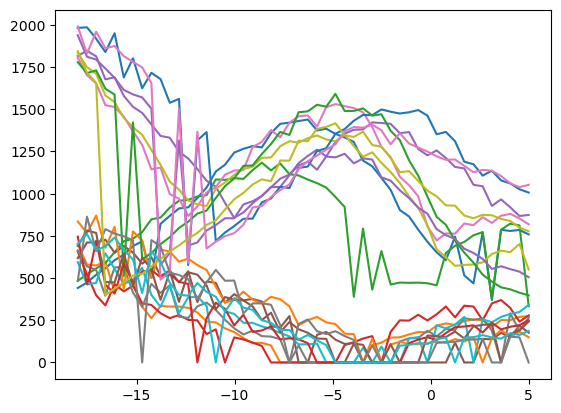

In [12]:
for i in range(10):
    plt.plot(power_scan,fir_amp_all[i])
    plt.plot(power_scan,zero_amp_all[i])

In [4]:
synthd.close()

[-0.20301619  0.18310253]


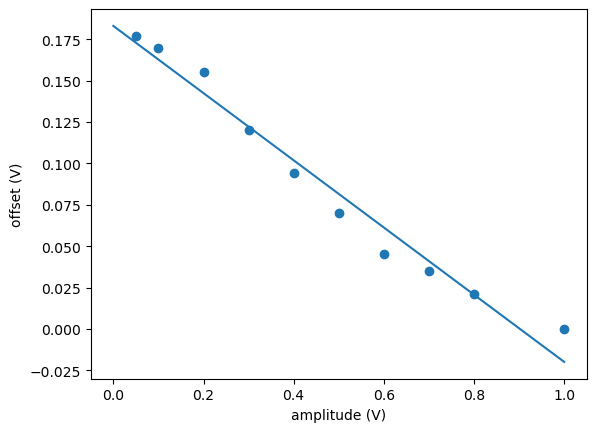

In [5]:
x=[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
y=[0,0.021,0.035,0.045,0.07,0.094,0.12,0.155,0.17,0.177]
xs=np.linspace(0,1,100)
poly = np.polyfit(x,y,1)
poly_y = np.poly1d(poly)(xs)
plt.scatter(x,y)
plt.plot(xs,poly_y)
plt.xlabel("amplitude (V)")
plt.ylabel("offset (V)")
print(poly)

[-0.19236805  0.19767   ]


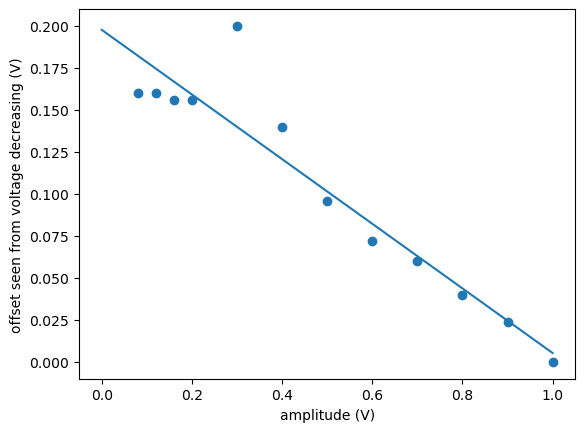

In [6]:

x=np.array([2.5,2.25,2,  1.75, 1.5,1.25,   1,0.75,0.5,0.4,0.3,0.2])/2.5 # to convert to input before opamp
y=np.array([0,  0.06,0.1,0.15,0.18,0.24,0.35,0.5,0.39,0.39,0.4,0.4])/2.5
xs=np.linspace(0,1,100)
poly = np.polyfit(x,y,1)
poly_y = np.poly1d(poly)(xs)
plt.scatter(x,y)
plt.plot(xs,poly_y)
plt.xlabel("amplitude (V)")
plt.ylabel("offset seen from voltage decreasing (V)")
print(poly)

In [7]:
x=[1,2,3,5,3,2,1]
print(np.argmax(x))

3
